In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.linalg as linalg
import os
import time
from PFlib.ParticleFilter import sample_normal_model, single_step_particle_filter, normal_model_pdf, single_step_particle_filter_measurement_window
from PFutils.plotting import draw_ellipse, images_to_gif
from PFutils.filesTools import get_exp_folder
from PFutils.notionConnector import add_experiment_to_notion
from pathlib import Path
import json
NOTEBOOK_NAME = "TBOD"

In [2]:
# Replace 'your_file.csv' with the path to your CSV file
df = pd.read_csv('TBOD_data.csv')

# modeling 
here we can define all the parameters relevent to our system. 

__spacial cases:__
- if we want a deterministic agent or beacon we can set his covariance to zero, this also need to be done in the particle initialization part 




In [3]:
## setup params
NUM_OF_BEACONS = 4
NUM_OF_AGENTS = 3
STATE_SIZE = 4
SINGLE_RANGE_MEASUREMENT_SIZE = 1
RANGE_MEASUREMENT_SIZE = NUM_OF_BEACONS * SINGLE_RANGE_MEASUREMENT_SIZE * NUM_OF_AGENTS
TOTAL_STATE_SIZE = NUM_OF_AGENTS * STATE_SIZE + NUM_OF_BEACONS * STATE_SIZE
sigma_transition_agent = 0.5
sigma_transition_beacon = 0
sigma_measurement = 0.1
stepsize = 0.1
n_steps = len(df)
# model definition
cov_measurement = np.diag([sigma_measurement**2 for i in range(RANGE_MEASUREMENT_SIZE)])
cov_transition_agent = [sigma_transition_agent**2, sigma_transition_agent**2, 1e-4] * NUM_OF_AGENTS
cov_transition_beacon = [sigma_transition_beacon**2 for i in range(NUM_OF_BEACONS*STATE_SIZE)]
cov_transition = np.diag(cov_transition_agent + cov_transition_beacon)
offset = -0.5
state_correction = 0 * np.array([0.23, 0.12, 0.0, 0.0])  # correction for the agent position


## State Manager
__not do be edited__ 
This section of the code is responsible for managing the state of the system, which includes the positions of agents and beacons in a 2D space.

Here's a breakdown of the functions:

- `get_agent_index(i)`: This function takes an agent's index `i` and returns a slice object that can be used to index into the state vector `x` to get the position of the agent.

- `get_beacon_index(i)`: Similar to `get_agent_index`, this function takes a beacon's index `i` and returns a slice object that can be used to index into the state vector `x` to get the position of the beacon.

- `get_agent_position(x, i)`: This function takes the state vector `x` and an agent's index `i`, and returns the position of the agent.

- `get_beacon_position(x, i)`: This function takes the state vector `x` and a beacon's index `i`, and returns the position of the beacon.

- `state_to_agent_and_beacons_pos(x)`: This function takes the state vector `x` and returns two arrays containing the positions of all agents and beacons, respectively.

- `agent_and_beacons_pos_to_state(agents_pos, beacons_pos)`: This function takes two arrays containing the positions of all agents and beacons, respectively, and returns a state vector `x`.

These functions are used to convert between the state vector representation and the separate agent and beacon position representations, which can be more convenient for certain calculations.

In [4]:
# state manger
get_agent_index = lambda i: slice(i*STATE_SIZE, i*STATE_SIZE + STATE_SIZE)
get_beacon_index = lambda i: slice(STATE_SIZE*NUM_OF_AGENTS + i*STATE_SIZE, STATE_SIZE*NUM_OF_AGENTS + i*STATE_SIZE + STATE_SIZE)
get_agent_position = lambda x, i: x[get_agent_index(i)]
get_beacon_postion = lambda x, j: x[get_beacon_index(j)]

def state_to_agent_and_beacons_pos(x):
    agents_pos = np.zeros((NUM_OF_AGENTS, STATE_SIZE))
    beacons_pos = np.zeros((NUM_OF_BEACONS, STATE_SIZE))
    for i in range(NUM_OF_AGENTS):
        agents_pos[i] = get_agent_position(x, i)
    for j in range(NUM_OF_BEACONS):
        beacons_pos[j] = get_beacon_postion(x, j)
    return agents_pos, beacons_pos

def agent_and_beacons_pos_to_state(agents_pos, beacons_pos):
    x = np.zeros(TOTAL_STATE_SIZE)
    for i in range(NUM_OF_AGENTS):
        x[get_agent_index(i)] = agents_pos[i]
    for j in range(NUM_OF_BEACONS):
        x[get_beacon_index(j)] = beacons_pos[j]
    return x

def calculate_mean_and_cov(particles):
    mean = np.mean(particles, axis = 0)
    cov = np.cov(particles.T).flatten()
    return mean, cov

## State Propagation and Measurement Model

This section of the code is responsible for propagating the state of the system and generating the measurement model.

Here's a breakdown of the functions:

- `propagate_state(x, u)`: This function propagates the state based on the control input `u` and a normal model. It adds a normally distributed noise with covariance `cov_transition` to the state `x`.

- `calculate_true_range_meas(x)`: This function calculates the true range measurements. It calculates the Euclidean distance between each agent and each beacon. The state vector `x` contains the positions of the agents and beacons.

- `measurements_model(x, cov = cov_measurement)`: This function generates the range measurements model. It adds a normally distributed noise with covariance `cov_measurement` to the true range measurements.

- `measurements_likelihood(z, x)`: This function calculates the likelihood of the measurements `z` given the state `x`. It uses a normal probability density function with the true range measurements as the mean and the measurement covariance as the covariance.

These functions are used to simulate the dynamics of the system and the measurements of the agents.

In [5]:
import math

## model definition
'''
Function to propagate the state based on the control input and a normal model
'''
propagate_state_function_random = lambda x, u: x + sample_normal_model(u, cov_transition)

L = 0.19
Z = 0  # If you want the tag to be at z=0, otherwise set as needed
TagPos = np.array([
    [-L,           0.0,         1*Z],
    [L*math.sin(math.pi/6),  -L*math.cos(math.pi/6),  1*Z],
    [L*math.sin(math.pi/6),   L*math.cos(math.pi/6),  1*Z]
]).T

def propagate_state_function(x, u):
    """
    Function to propagate the state based on the control input.
    It adds the control input to the agent's position.
    """
    x = x.copy()
    
    # get barycenter of tags
    x_center = np.zeros(3)
    theta_center = x[get_agent_index(0)][3]
    R = np.array([
        [np.cos(theta_center), -np.sin(theta_center), 0],
        [np.sin(theta_center),  np.cos(theta_center), 0],
        [0,                   0,                    1]
    ])        
    for i in range(NUM_OF_AGENTS):
        # get the barycenter position through the measurement of the tags
        x_center += (x[get_agent_index(i)][:3])
        
        # get the barycenter orientation
        x[get_agent_index(i)][3] = x[get_agent_index(0)][3]           
    x_center /= NUM_OF_AGENTS    
    
    # propagate agent position
    x_center += u[:3]
    theta_center += u[3]    
    
    # update the agent positions
    R = np.array([
        [np.cos(theta_center), -np.sin(theta_center), 0],
        [np.sin(theta_center),  np.cos(theta_center), 0],
        [0,                   0,                    1]
    ])
    for i in range(NUM_OF_AGENTS):
        x[get_agent_index(i)][:3] =  (R @ TagPos[:, i] + x_center )
        x[get_agent_index(i)][3] = theta_center
    
    return x

def propagate_state_function_singleagent(x, u):
    """
    Function to propagate the state based on the control input.
    It adds the control input to the agent's position.
    """
    
    x = x.copy()
    for i in range(NUM_OF_AGENTS):
        x[get_agent_index(i)] += u[i*STATE_SIZE:(i+1)*STATE_SIZE]
    return x

def get_range_meas(df, time_index):
    """
    Function to calculate the true range measurements.
    It calculates the Euclidean distance between each agent and each beacon.
    """
    z = np.zeros(RANGE_MEASUREMENT_SIZE)
    for i in range(NUM_OF_AGENTS):    
        tag_number = i + 1    
        for j in range(NUM_OF_BEACONS):  
            name = 'DT' + str(tag_number) + 'A' + str(j+1)
            # name = 'DG' + 'A' + str(j+1)
            z[i*NUM_OF_BEACONS + j] = df[name][time_index]
    return z

def calculate_true_range_meas(x):
    """
    Function to calculate the true range measurements.
    It calculates the Euclidean distance between each agent and each beacon.
    """
    z = np.zeros(RANGE_MEASUREMENT_SIZE)
    for i in range(NUM_OF_AGENTS):
        current_agent_position = x[get_agent_index(i)][:3]
        for j in range(NUM_OF_BEACONS):
            current_beacon_position = x[get_beacon_index(j)][:3]
            z[i*NUM_OF_BEACONS + j] = np.linalg.norm(current_agent_position - current_beacon_position)
    return z

def measurements_model(x, cov = cov_measurement):
    '''
    Function to generate the range measurements model.
    It adds a normally distributed noise to the true range measurements.
    '''
    return calculate_true_range_meas(x) + sample_normal_model(np.zeros(RANGE_MEASUREMENT_SIZE), cov)

'''
function to calculates the likelihood of the measurements given the state.
It uses a normal probability density function with the true range measurements
as the mean and the measurement covariance as the covariance
'''
measurements_likelihood_csv = lambda z, df, tag_number, time_index: normal_model_pdf(z, get_range_meas(df, tag_number, time_index), cov_measurement)
measurements_likelihood = lambda z, x: normal_model_pdf(z, calculate_true_range_meas(x), cov_measurement)

## Ground Truth Generation

This section of the code is responsible for generating the ground truth state and measurements of the system.

Here's a breakdown of the code:

- The initial positions of the agent and the beacons are defined.

- The state vector `x_0` is initialized with these positions.

- The control input `u` is generated. It is a random vector with values between `-0.5 * stepsize` and `0.5 * stepsize`. The control input for the agent and each beacon is generated separately.

- The ground truth state `x` and measurements `z` are initialized with zeros. The first column of `x` is set to `x_0` and the first column of `z` is set to the measurements model of `x_0`.

- A loop is used to propagate the state and generate the measurements for each time step. The `propagate_state` function is used to propagate the state based on the previous state and the control input. The `measurements_model` function is used to generate the measurements based on the current state.

- An optional plot is included to visualize the ground truth state. The positions of the agent and each beacon are plotted over time.

This section of the code is used to simulate the true dynamics of the system and generate the true measurements, which will be used to evaluate the performance of the particle filter.

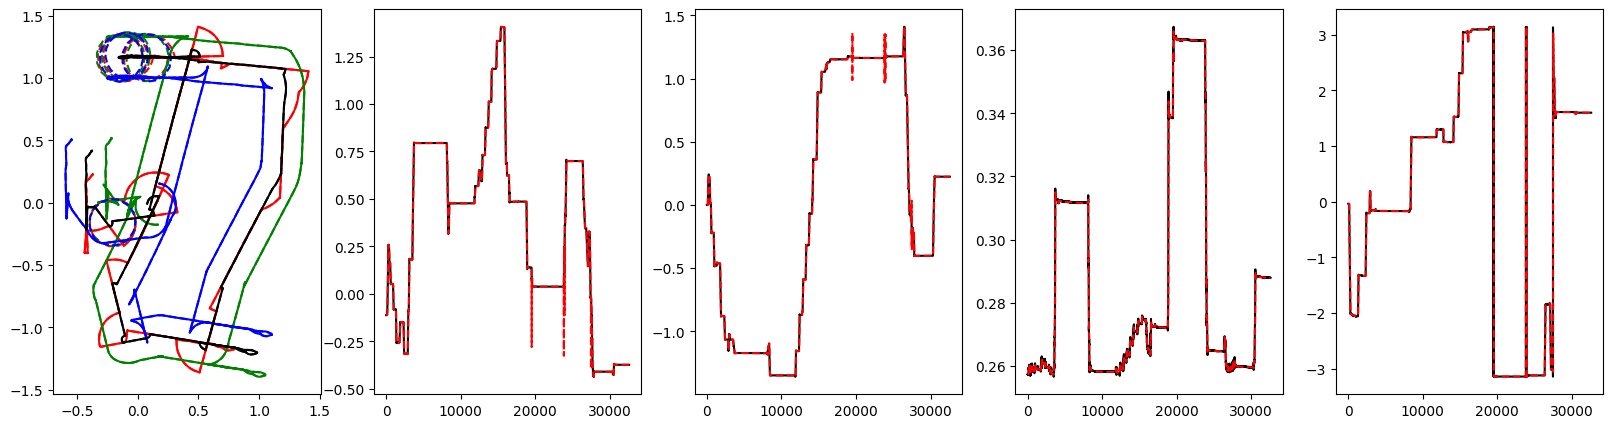

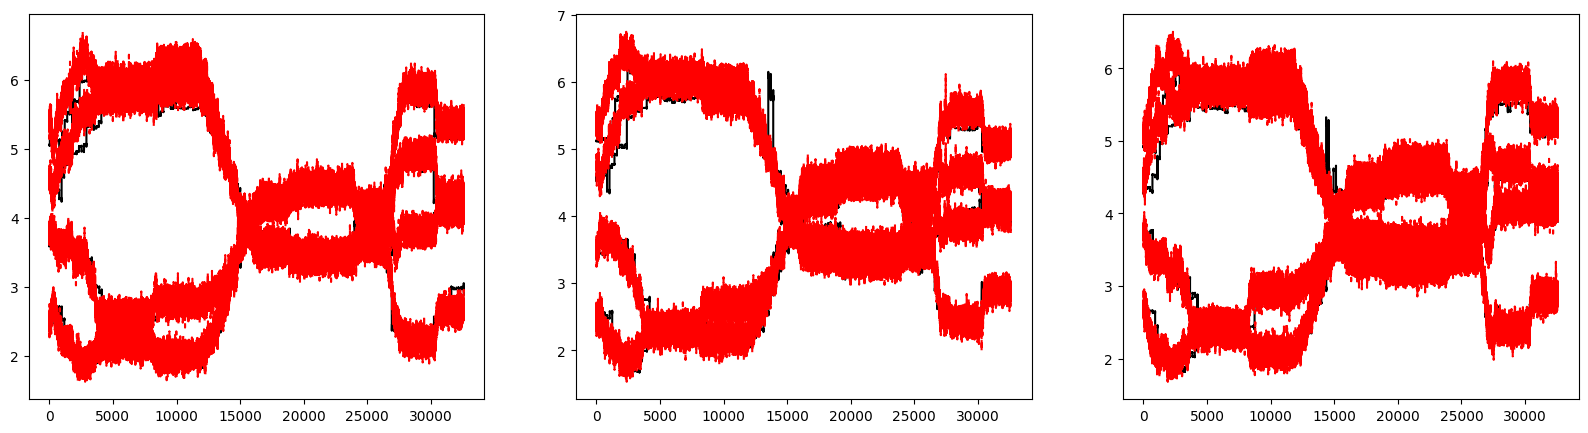

In [6]:
scale = 0.1
scale_omega = 0.1

## generate ground truth
theta_center_0 = df['GTYA'][0]  # initial orientation of the agent
R = np.array([
    [np.cos(theta_center_0), -np.sin(theta_center_0), 0],
    [np.sin(theta_center_0),  np.cos(theta_center_0), 0],
    [0,                   0,                    1]
])
# Repeat for each agent (NUM_OF_AGENTS times)
agent_position_0 = []
for i in range(NUM_OF_AGENTS):
    agent_position_0.append(np.zeros((STATE_SIZE,)))
    x_center_0 = np.array([df['GTX'][0], df['GTY'][0], df['GTZ'][0]]) + state_correction[:3]
    agent_position_0[i][:STATE_SIZE-1] = (R @ TagPos[:,i] + x_center_0)
    agent_position_0[i][STATE_SIZE-1] = (theta_center_0)  # add orientation
agent_position_0 = np.array(agent_position_0)
becons_1_position_0 = np.array([-0.40,+4.20, +2.00, +0.0])
becons_2_position_0 = np.array([-0.40,-1.80, +2.00, +0.0])
becons_3_position_0 = np.array([+2.48,-2.20, +2.00, +0.0])
becons_4_position_0 = np.array([+2.80,+4.20, +2.00, +0.0])
x_0 = agent_and_beacons_pos_to_state(agent_position_0, [becons_1_position_0, becons_2_position_0, becons_3_position_0, becons_4_position_0])

#genrate u  commend vector
u = np.zeros((TOTAL_STATE_SIZE, n_steps))
# u[get_agent_index(0),:] = (np.random.rand(STATE_SIZE, n_steps) + offset) * scale
u[get_agent_index(0),:] = ((df['GTVX'][0:n_steps]) * scale ,
                           (df['GTVY'][0:n_steps]) * scale, 
                           (df['GTVZ'][0:n_steps]) * scale, 
                           (df['GTOMEGA'][0:n_steps]) * scale_omega)

## create ground truth - model
x_model = np.zeros((TOTAL_STATE_SIZE, n_steps))
x_model[:,0] = x_0
z_model = np.zeros((RANGE_MEASUREMENT_SIZE, n_steps))
z_model[:,0] = measurements_model(x_model[:,0], cov=cov_measurement)

## create ground truth - csv
x_csv = np.zeros((TOTAL_STATE_SIZE, n_steps))
x_csv[:,0] = x_0
z_csv = np.zeros((RANGE_MEASUREMENT_SIZE, n_steps))
z_csv[:,0] = get_range_meas(df, time_index=0)

# velocity in the ground truth
vx = np.stack([df['GTVX'][0:n_steps], df['GTVY'][0:n_steps], df['GTVZ'][0:n_steps], df['GTOMEGA'][0:n_steps]], axis=1)

for i in range(1, n_steps): 
    # state propagation - csv   
    x_csv[:,i] = x_csv[:,i-1]
    theta_center = df['GTYA'][i]
    R = np.array([
        [np.cos(theta_center), -np.sin(theta_center), 0],
        [np.sin(theta_center),  np.cos(theta_center), 0],
        [0,                   0,                    1]
    ])
    x_center = np.array([df['GTX'][i], df['GTY'][i], df['GTZ'][i]]) + state_correction[:3]
    for j in range(NUM_OF_AGENTS):        
        x_csv[get_agent_index(j), i][:STATE_SIZE-1] = (R @ TagPos[:,j] + x_center)
        x_csv[get_agent_index(j), i][STATE_SIZE-1] = (theta_center)  # add orientation
    z_csv[:,i] = get_range_meas(df, time_index=i)
    
    # state propagation - model
    x_model[:,i] = propagate_state_function(x_model[:,i-1], u[:,i-1]) 
    z_model[:,i] = measurements_model(x_model[:,i], cov=cov_measurement)           
    
# GT is the average of the agents' positions
GT_model = np.zeros((STATE_SIZE, n_steps))
GT_csv = np.zeros((STATE_SIZE, n_steps))
for i in range(n_steps):
    # GT from csv
    for j in range(NUM_OF_AGENTS):
        GT_csv[0,i] += x_csv[j*STATE_SIZE + 0,i]
        GT_csv[1,i] += x_csv[j*STATE_SIZE + 1,i]
        GT_csv[2,i] += x_csv[j*STATE_SIZE + 2,i]
        GT_csv[3,i] += x_csv[j*STATE_SIZE + 3,i]
    GT_csv[:4,i] /= NUM_OF_AGENTS
    # GT_csv[:4,i] = np.array([df['GTX'][i], df['GTY'][i], df['GTZ'][i], df['GTOMEGA'][i]])
    # GT from model
    for j in range(NUM_OF_AGENTS):
        GT_model[0,i] += x_model[j*STATE_SIZE + 0,i]
        GT_model[1,i] += x_model[j*STATE_SIZE + 1,i]
        GT_model[2,i] += x_model[j*STATE_SIZE + 2,i]
        GT_model[3,i] += x_model[j*STATE_SIZE + 3,i]
    GT_model[:4,i] /= NUM_OF_AGENTS 
    
from scipy.signal import resample
target_len = z_model.shape[1]
z_csv = resample(z_csv[:,:(target_len-int(n_steps*7500/len(df)))], target_len, axis=1)

## plot ground truth
if 1:
    fig, ax = plt.subplots(1, 5, figsize=(20, 5))
    
    # TAG 1
    ax[0].plot(x_csv[0*(STATE_SIZE) + 0,:], x_csv[0*(STATE_SIZE) + 1,:], 'r')
    ax[0].plot(x_model[0*(STATE_SIZE) + 0,:], x_model[0*(STATE_SIZE) + 1,:], 'r--')
    
    # TAG 2
    ax[0].plot(x_csv[1*(STATE_SIZE) + 0,:], x_csv[1*(STATE_SIZE) + 1,:], 'g')
    ax[0].plot(x_model[1*(STATE_SIZE) + 0,:], x_model[1*(STATE_SIZE) + 1,:], 'g--')
    
    # TAG 3
    ax[0].plot(x_csv[2*(STATE_SIZE) + 0,:], x_csv[2*(STATE_SIZE) + 1,:], 'b')
    ax[0].plot(x_model[2*(STATE_SIZE) + 0,:], x_model[2*(STATE_SIZE) + 1,:], 'b--')
    
    # GT
    ax[0].plot(GT_csv[0,:], GT_csv[1,:], 'k', label='GT_csv')
    ax[0].plot(GT_model[0,:], GT_model[1,:], 'k--', label='GT_model')    
    
    # anchors
    # ax[0].scatter(x[NUM_OF_AGENTS * STATE_SIZE,:], x[NUM_OF_AGENTS * STATE_SIZE + 1,:], color = 'g')
    # ax[0].scatter(x[(NUM_OF_AGENTS + 1) * STATE_SIZE,:], x[(NUM_OF_AGENTS + 1) * STATE_SIZE + 1,:], color = 'b')
    # ax[0].scatter(x[(NUM_OF_AGENTS + 2) * STATE_SIZE,:], x[(NUM_OF_AGENTS + 2) * STATE_SIZE + 1,:], color = 'y')
    # ax[0].scatter(x[(NUM_OF_AGENTS + 3) * STATE_SIZE,:], x[(NUM_OF_AGENTS + 3) * STATE_SIZE + 1,:], color = 'm')    
    
    # plot the Gt and derivatives
    for i in range(4):        
        ax[i+1].plot(x_csv[i,:], 'k')
        ax[i+1].plot(x_model[i,:], 'r--')
    plt.show()
    
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
    for i in range(NUM_OF_AGENTS):
        ax[i].plot(z_csv[i*NUM_OF_BEACONS:(i+1)*NUM_OF_BEACONS,:].T, 'k')
        ax[i].plot(z_model[i*NUM_OF_BEACONS:(i+1)*NUM_OF_BEACONS,:].T, 'r--')
    plt.show()
        
        
        


## Function: run_particle_filter_experiment

This function runs a particle filter experiment and logs the results.

Here's a breakdown of the function:

- `note`: A string that describes the current experiment.

- `n_steps`: The number of steps to run the particle filter.

- `total_state_size`: The size of the state vector.

- `x`: The ground truth state.

- `u`: The control input.

- `z`: The measurements.

- `propagate_state_function`: A function that propagates the state based on the control input.

- `measurements_likelihood_function`: A function that calculates the likelihood of the measurements given the state.

- `resample_method`: The method used for resampling particles. Default is 'systematic'.

- `save_particles`: A boolean that determines whether to save each frame of the particle filter's operation. Default is `False`.

- `ellipse`: A boolean that determines whether to draw an ellipse around the particles. Default is `True`.

The function runs the particle filter for `n_steps` steps, saves the particles and the ground truth state and measurements, and generates a GIF and CSV files of the results. It returns the mean log, covariance log, and the experiment folder.

In [7]:
def run_particle_filter_experiment(note,particles, 
                                   n_steps, 
                                   total_state_size, 
                                   x, u, z,                                   
                                   propagate_state_function, 
                                   measurements_likelihood_function, 
                                   params_log, resample_method='systematic', 
                                   save_particles=False, 
                                   ellipse=True):
        
    mean_log = np.zeros((n_steps, total_state_size))
    cov_log = np.zeros((n_steps, total_state_size**2))

    for i in range(n_steps):        
        
        particles = single_step_particle_filter(particles, u[:,i], z[:,i], propagate_state_function, measurements_likelihood_function, resample_method = resample_method)
        mean_log[i], cov_log[i] = calculate_mean_and_cov(particles)
        print(f"\r{i}/{n_steps}", end='', flush=True)
    print('\n')    
    return mean_log, cov_log, particles

## Particle Filter Parameters and Initialization

This section of the code is responsible for setting up the parameters for the particle filter and initializing the particles.

Here's a breakdown of the code:

- `NOTE`: A string that describes the current experiment.

- `SAVE_EACH_FRAME`: A boolean that determines whether to save each frame of the particle filter's operation.

- `n_particles`: The number of particles to use in the particle filter.

- `particles`: The particles are initialized with random positions within a square of side length 15 centered at the origin. The agent's position is initialized at the origin.

- `r`, `theta`, `beacons_pos_0`: These variables are used to initialize the positions of the beacons in a circle around the agent.

- The commented out lines of code show alternative ways to initialize the positions of the beacons.

- `save_current_particles`: This function is used to save the current particles. If `SAVE_EACH_FRAME` is `True`, it calls the `_save_current_particles` function to save the particles to a file. If `SAVE_EACH_FRAME` is `False`, it does nothing.

This section of the code is used to set up the particle filter and initialize the particles, which represent the estimated state of the system.

In [8]:

## particle filter paerameters and initialization
NOTE = 'simple_single_agent_moving'
SAVE_EACH_FRAME = 1
n_particles = 1000
particles = (np.random.rand(n_particles, TOTAL_STATE_SIZE) + offset) * 5
particles[:,get_beacon_index(0)] = becons_1_position_0
particles[:,get_beacon_index(1)] = becons_2_position_0
particles[:,get_beacon_index(2)] = becons_3_position_0
particles[:,get_beacon_index(3)] = becons_4_position_0

# x = x_model.copy()
# z = z_model.copy()
x = x_csv.copy()
z = z_csv.copy()

(mean_log, cov_log, particles) = run_particle_filter_experiment(note = NOTE,
                                                                            n_steps= n_steps,
                                                                            particles = particles,
                                                                            total_state_size = TOTAL_STATE_SIZE,
                                                                            x = x,
                                                                            u = u,
                                                                            z = z,                                                                            
                                                                            propagate_state_function=propagate_state_function,
                                                                            measurements_likelihood_function = measurements_likelihood,
                                                                            params_log=[],
                                                                            resample_method='systematic',
                                                                            save_particles=False,
                                                                            ellipse=True)

32586/32587



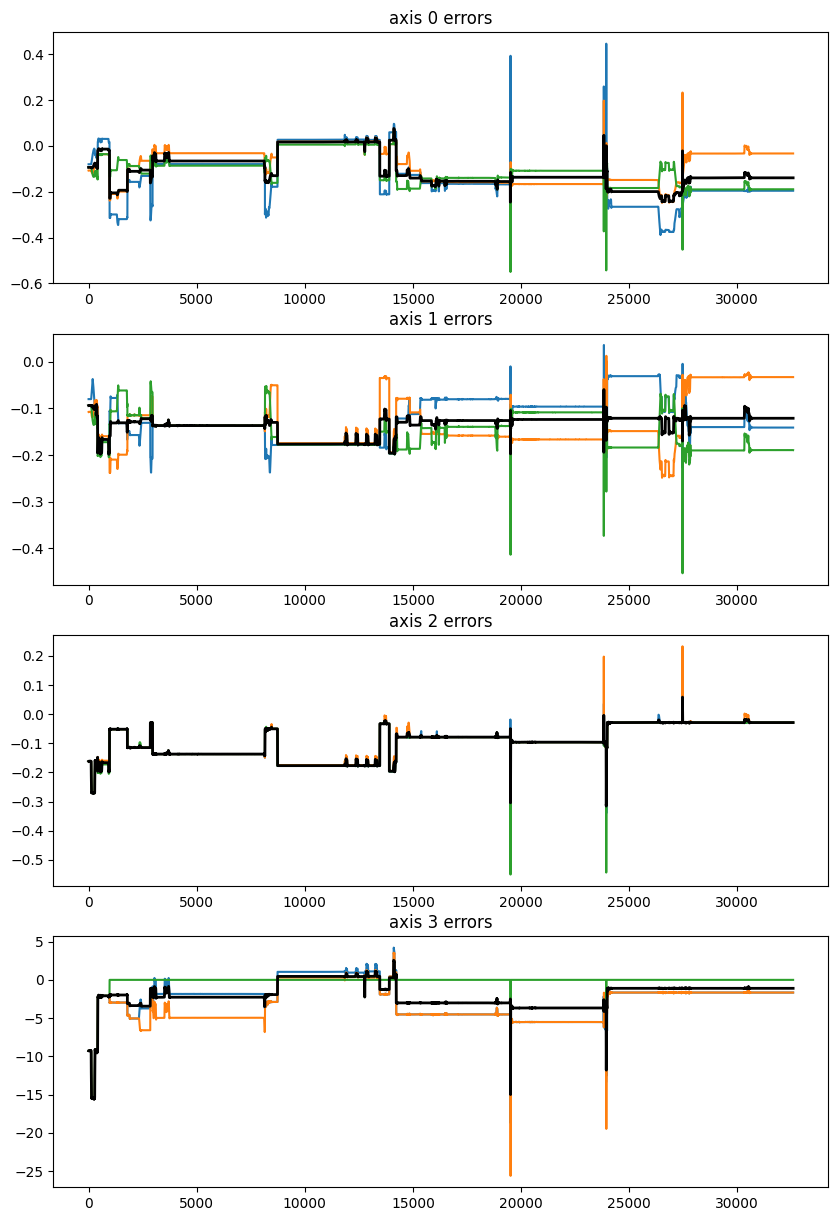

Errors:
axis 0: mean: -0.109, std: 0.070, mean abs: 0.115, std abs: 0.060, RMSE: 0.130
axis 1: mean: -0.135, std: 0.020, mean abs: 0.135, std abs: 0.020, RMSE: 0.137
axis 2: mean: -0.095, std: 0.055, mean abs: 0.095, std abs: 0.055, RMSE: 0.109
axis 3: mean: -1.967, std: 1.790, mean abs: 2.118, std abs: 1.608, RMSE: 2.660


In [9]:
from scipy.ndimage import median_filter

#calc errors
errors = np.zeros((n_steps, TOTAL_STATE_SIZE))
error_mean = []
for i in range(n_steps):
    errors[i] = x[:,i] - mean_log[i]
    errors[i] = median_filter(errors[i], size=3)

#plot errors, split by aagent and beacons in different subplots for each agent and beacon

fig, axs = plt.subplots(4, 1, figsize=(10, 15))
for i in range(4):
    store = np.zeros((n_steps))
    for j in range(NUM_OF_AGENTS):
        if i < 3:                
            store += errors[:,i + 4*j]
            axs[i].plot(errors[:,i + 4*j])
        else:
            # Convert radians to degrees for orientation (axis 3)
            if i == 3:
                store += np.rad2deg(errors[:, i + 4*j])
                axs[i].plot(np.rad2deg(errors[:, i + 4*j]))
            else:
                store += errors[:, i + 4*j]
                axs[i].plot(errors[:, i + 4*j])                
    store /= NUM_OF_AGENTS
    error_mean.append([np.mean(store), np.std(store), np.mean(abs(store)), np.std(abs(store)), np.sqrt(np.mean(store**2))])
    axs[i].plot(store, 'k', linewidth=2, label='mean error')
    axs[i].set_title(f'axis {i} errors')    
plt.show()

# errors
print('Errors:')
for i in range(4):
    print(f'axis {i}: mean: {error_mean[i][0]:.3f}, std: {error_mean[i][1]:.3f}, mean abs: {error_mean[i][2]:.3f}, std abs: {error_mean[i][3]:.3f}, RMSE: {error_mean[i][4]:.3f}')